In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [762]:
# Trade data

stock_name = 'GOOGL.O'
#NSQ_OneYear100closeA_Sept21.csv
df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [763]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Model 1A

Question 1A: How well does $\sigma_{t}^{2}$ forecast $\sigma_{t+1}^{2}$ ? Is it biased?

In [764]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
avg_20day_volatility = []

prices_350 = []
prices_auction = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    
    volatility_today = [val for val in apple_today_10min['Volatility'].values]
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    prices_350.append(apple_today_10min.iloc[-1]['Open'])
    prices_auction.append(apple_auction_today.iloc[0]['Price'])
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # Change the 39th 10min interval to include the auction price (instead of close)
    auction_volatility = np.sqrt(0.5*np.square(np.log(apple_today_10min['High'][-1]/apple_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1])))
    volatility_today[-1] = auction_volatility
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Daily raw return
    daily_return.append(return_today)
        
    # Auction Volatility Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model


In [765]:
df_mod1A = pd.DataFrame()
r1 = volatility_df['Date'].values
df_mod1A['Date'] = r1[20:]
df_mod1A['Actual Volatility'] = daily_volatility[20:]
df_mod1A['Predicted Volatility'] = avg_20day_volatility_raw[20:] # span=20 EWMA up to t-1

In [766]:
df_mod1A

,Date,Actual Volatility,Predicted Volatility
0,2020-09-30,0.086464,0.094576
1,2020-10-01,0.077917,0.093696
2,2020-10-02,0.097555,0.092006
3,2020-10-05,0.061457,0.092593
4,2020-10-06,0.091812,0.089333
...,...,...,...
226,2021-08-26,0.037413,0.043962
227,2021-08-27,0.040490,0.043338
228,2021-08-30,0.035938,0.043067
229,2021-08-31,0.036280,0.042388


In [767]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(mean_absolute_error(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))
print(mean_squared_error(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))
print(r2_score(df_mod1A['Actual Volatility'][-211:], df_mod1A['Predicted Volatility'][-211:]))

0.014733082253569327
0.0003934077036643071
0.42933444020259304


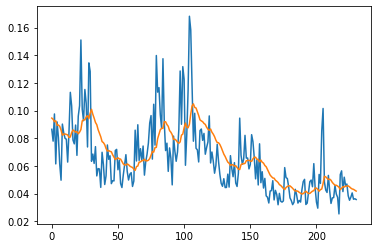

In [768]:
plt.plot(df_mod1A['Actual Volatility'])
plt.plot(df_mod1A['Predicted Volatility'])

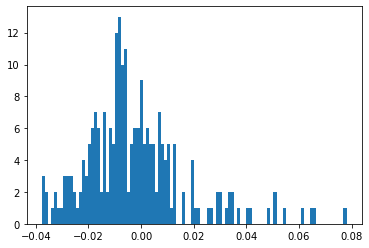

In [769]:
plt.hist(df_mod1A['Actual Volatility'] - df_mod1A['Predicted Volatility'], bins=100)
plt.show()

### Model 1B

Question 1B: How well does $\sigma_{t,B}^{2}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased?

In [770]:
volatility_df['auction'] = volatility_df['daily_volatility'] - volatility_df['daily_volatility_minus4pm']
volatility_df['volatility_ewma20_minus4pm'] = np.array([None] + [i for i in volatility_df['daily_volatility_minus4pm'].ewm(span=20).mean()][:-1])
volatility_df['volatility_ewma20_auction'] = np.array([None] + [i for i in volatility_df['auction'].ewm(span=20).mean()][:-1])
volatility_df

,Date,daily_volatility,daily_volatility_minus4pm,volatility_ewma20,auction,volatility_ewma20_minus4pm,volatility_ewma20_auction
0,2020-09-01,0.061950,0.058720,None,0.003230,None,None
1,2020-09-02,0.088641,0.085249,0.06195,0.003391,0.05872,0.00323
2,2020-09-03,0.160063,0.152205,0.075963,0.007858,0.072648,0.003315
3,2020-09-04,0.196968,0.194313,0.106844,0.002656,0.101861,0.004983
4,2020-09-08,0.137512,0.133745,0.132861,0.003767,0.12855,0.004311
...,...,...,...,...,...,...,...
246,2021-08-26,0.037413,0.035585,0.043962,0.001828,0.042406,0.001556
247,2021-08-27,0.040490,0.038427,0.043338,0.002063,0.041756,0.001582
248,2021-08-30,0.035938,0.034838,0.043067,0.001100,0.041439,0.001628
249,2021-08-31,0.036280,0.033199,0.042388,0.003081,0.040811,0.001578


In [771]:
df_mod1B = pd.DataFrame()
df_mod1B['Date'] = volatility_df['Date'][20:]
df_mod1B['Actual Volatility'] = volatility_df['auction'][20:]
df_mod1B['Predicted Volatility'] = volatility_df['volatility_ewma20_auction'][20:]

In [772]:
df_mod1B

,Date,Actual Volatility,Predicted Volatility
20,2020-09-30,0.004663,0.003318
21,2020-10-01,0.001794,0.003464
22,2020-10-02,0.002233,0.003285
23,2020-10-05,0.001811,0.003174
24,2020-10-06,0.004109,0.003031
...,...,...,...
246,2021-08-26,0.001828,0.001556
247,2021-08-27,0.002063,0.001582
248,2021-08-30,0.001100,0.001628
249,2021-08-31,0.003081,0.001578


In [773]:
print(mean_absolute_error(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))
print(mean_squared_error(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))
print(r2_score(df_mod1B['Actual Volatility'][-211:], df_mod1B['Predicted Volatility'][-211:]))

0.0007979580031086964
1.1800501267088853e-06
0.22967443465900572


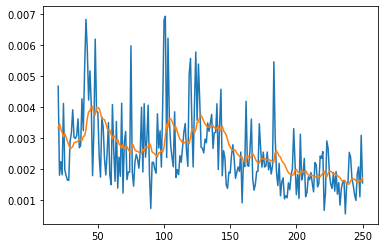

In [774]:
plt.plot(df_mod1B['Actual Volatility'])
plt.plot(df_mod1B['Predicted Volatility'])

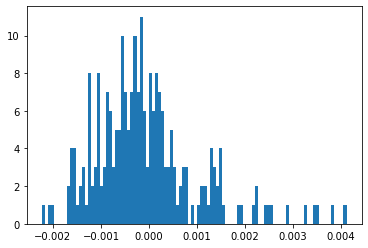

In [775]:
plt.hist(df_mod1B['Actual Volatility'] - df_mod1B['Predicted Volatility'], bins=100)
plt.show()

### Model 1C

Question 1C: How well does $\gamma\sigma_{t}^{2}$, where $\gamma = \dfrac{\sigma_{t+1,A}^{2}}{\sigma_{t,A}^{2}}$ forecast $\sigma_{t+1,B}^{2}$ ? Is it biased? \
(A corresponds to 9:30:00 to 15:49:59\
B corresponds to 15:50:00 to 16:00:00)

In [776]:
volatility_df['volatility_ewma20_minus4pm_yest'] = volatility_df['volatility_ewma20_minus4pm'].shift(1)
volatility_df['volatility_ewma20_auction_1c'] = volatility_df['daily_volatility_minus4pm']/volatility_df['volatility_ewma20_minus4pm_yest']*volatility_df['volatility_ewma20_auction']


In [777]:
df_mod1C = pd.DataFrame()
df_mod1C['Date'] = volatility_df['Date'][20:]
df_mod1C['Actual_Volatility'] = volatility_df['auction'][20:]
df_mod1C['Predicted_Volatility'] = volatility_df['volatility_ewma20_auction_1c'][20:]

In [778]:
print(mean_absolute_error(df_mod1C['Actual_Volatility'][-211:], df_mod1C['Predicted_Volatility'][-211:]))
print(mean_squared_error(df_mod1C['Actual_Volatility'][-211:], df_mod1C['Predicted_Volatility'][-211:]))
print(r2_score(df_mod1C['Actual_Volatility'][-211:], df_mod1C['Predicted_Volatility'][-211:]))

0.0007413572102139179
1.046161732618309e-06
0.3170755124064978


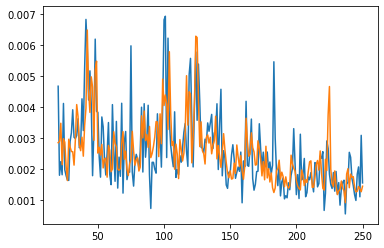

In [779]:
plt.plot(df_mod1C['Actual_Volatility'])
plt.plot(df_mod1C['Predicted_Volatility'])

In [780]:
prices_350 = prices_350[40:]
prices_auction = prices_auction[40:]
sigma = np.array(df_mod1C['Predicted_Volatility'])[20:]

In [781]:
# Hit Ratio Calculation

predicted_auction_price1 = [(prices_350[i] * np.exp(sigma[i] * -1), prices_350[i] * np.exp(sigma[i] * 1)) for i in range(211)]
predicted_auction_price2 = [(prices_350[i] * np.exp(sigma[i] * -2), prices_350[i] * np.exp(sigma[i] * 2)) for i in range(211)]
predicted_auction_price3 = [(prices_350[i] * np.exp(sigma[i] * -3), prices_350[i] * np.exp(sigma[i] * 3)) for i in range(211)]

hit1 = 0
hit2 = 0
hit3 = 0
for i in range(211):
    if prices_auction[i] > predicted_auction_price1[i][0] and prices_auction[i] < predicted_auction_price1[i][1]:
        hit1 += 1
    if prices_auction[i] > predicted_auction_price2[i][0] and prices_auction[i] < predicted_auction_price2[i][1]:
        hit2 += 1
    if prices_auction[i] > predicted_auction_price3[i][0] and prices_auction[i] < predicted_auction_price3[i][1]:
        hit3 += 1
        
print('Hit Ratio for 1SD is:', hit1/211)
print('Hit Ratio for 2SD is:', hit2/211)
print('Hit Ratio for 3SD is:', hit3/211)


Hit Ratio for 1SD is: 0.6492890995260664
Hit Ratio for 2SD is: 0.9241706161137441
Hit Ratio for 3SD is: 0.990521327014218


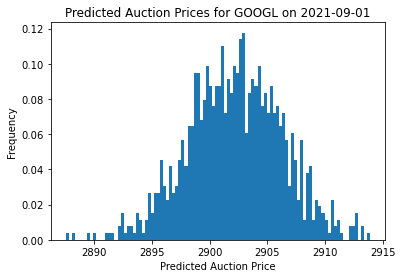

In [915]:
sigma = np.array(df_mod1C['Predicted_Volatility'])[20:]
s = [prices_350[-1] * np.exp(sigma[-1] * np.random.normal(0,1,1)[0]) for i in range(1000)]

count, bins, ignored = plt.hist(s, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)

plt.xlabel("Predicted Auction Price")
plt.ylabel("Frequency")
plt.title('Predicted Auction Prices for GOOGL on 2021-09-01')
plt.axis('tight')
plt.show()

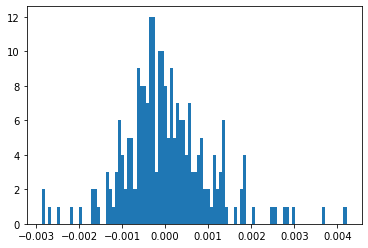

In [754]:
plt.hist(df_mod1C['Actual_Volatility'] - df_mod1C['Predicted_Volatility'], bins=100)
plt.show()

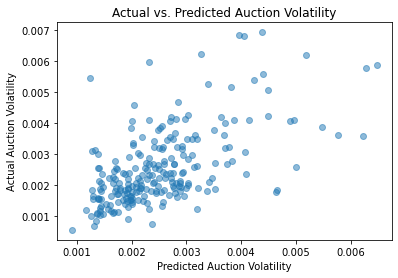

In [755]:
import matplotlib.lines as mlines

plt.scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
plt.xlabel("Predicted Auction Volatility")
# plt.xlim([0.0005, 0.0060])
plt.ylabel("Actual Auction Volatility")
plt.title('Actual vs. Predicted Auction Volatility')
plt.show()

In [756]:
import statsmodels.api as sm

X = df_mod1C['Predicted_Volatility']
Y = df_mod1C['Actual_Volatility']

model = sm.OLS(Y, X.astype(float)).fit() 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:      Actual_Volatility   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1570.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                   9.94e-105
Time:                        14:53:11   Log-Likelihood:                          1265.5
No. Observations:                 231   AIC:                                     -2529.
Df Residuals:                     230   BIC:                                     -2526.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------